In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mstats
import matplotlib.pyplot as plt

In [2]:
sc_daily_obs_df = pd.read_pickle("../01_create/sc_only_daily_obs_20240130.pkl")
sc_daily_obs_df["week"] = pd.to_datetime(sc_daily_obs_df["date"]).dt.to_period('W-SAT').dt.start_time
sc_daily_obs_df.sort_values(by=["pool_address","position_id", "date"], inplace=True)
nft_type_mapping = sc_daily_obs_df[["pool_address", "nf_position_manager_address","is_verified_sc"]].drop_duplicates()

In [3]:
unique_nft_managers = nft_type_mapping["nf_position_manager_address"].unique()

In [4]:
nft_type_mapping.to_csv("unique_nft_managers.csv")

In [5]:
weekly_agg_prices = pd.read_csv("weekly_agg_0411.csv") 

In [6]:
# read in the original data (pool action information)
pool_addrs = ['0x11b815efb8f581194ae79006d24e0d814b7697f6',
              '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
              '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
              '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8']
pool_action_infos = pd.DataFrame()
for pool_addr in pool_addrs:
    pool_action_info = pd.read_csv("../../data/raw/lp_data/" + pool_addr + "_fixed.csv", low_memory=False)
    pool_action_infos = pd.concat([pool_action_infos, pool_action_info], ignore_index=True)

In [7]:
sc_nf_positions = sc_daily_obs_df["nf_position_manager_address"].unique()
pool_action_info_sc = pool_action_infos[pool_action_infos["nf_position_manager_address"].isin(sc_nf_positions)].copy()
pool_action_info_sc["week"] = pd.to_datetime(pool_action_info_sc["block_timestamp"]).dt.to_period('W-SAT').dt.start_time

In [8]:
pool_action_info_sc.head(10)

,blockchain,block_number,block_timestamp,tx_hash,action,amount0_adjusted,amount1_adjusted,amount0_usd,amount1_usd,token0_address,...,price_lower_1_0_usd,price_upper_1_0_usd,price_lower_0_1_usd,price_upper_0_1_usd,tx_fee,from_address,to_address,token_id,Unnamed: 0,week
10025,ethereum,15128157,2022-07-12 13:46:55.000,0x1d6611077fbfd8d54192fa8733c66e77cedfe0e90566...,INCREASE_LIQUIDITY,0.034108,31.330926,36.604615,31.305773,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,474.988841,2890.546947,0.370981,2.257604,0.009175,0xa89a0e0906b2ce755f939572d698a1af29fc6c21,0x12cc705bdd9ff7cd3bcddafe1cabfce9a182aa22,-1.0,NaN,2022-07-10
10026,ethereum,15128157,2022-07-12 13:46:55.000,0x1d6611077fbfd8d54192fa8733c66e77cedfe0e90566...,DECREASE_LIQUIDITY,1.463823,1344.639859,1570.972578,1343.560369,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,474.988841,2890.546947,0.370981,2.257604,0.009175,0xa89a0e0906b2ce755f939572d698a1af29fc6c21,0x12cc705bdd9ff7cd3bcddafe1cabfce9a182aa22,-1.0,NaN,2022-07-10
10027,ethereum,15128157,2022-07-12 13:46:55.000,0x1d6611077fbfd8d54192fa8733c66e77cedfe0e90566...,DECREASE_LIQUIDITY,0.000000,0.000000,0.000000,0.000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,474.988841,2890.546947,0.370981,2.257604,0.009175,0xa89a0e0906b2ce755f939572d698a1af29fc6c21,0x12cc705bdd9ff7cd3bcddafe1cabfce9a182aa22,-1.0,NaN,2022-07-10
10028,ethereum,14769371,2022-05-13 19:56:09.000,0x77588092e039ba7b4797161a81d20c418a7e5fc7d132...,DECREASE_LIQUIDITY,0.000000,0.000000,0.000000,0.000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,1710.361851,2334.247124,0.881926,1.203624,0.026392,0xf6ada09f201691a5372ec2bb31e00d86c65fd0e2,0x34e9e83608790e91ebd14f0f84da35bb21cbd3f5,-1.0,NaN,2022-05-08
10029,ethereum,14769371,2022-05-13 19:56:09.000,0x77588092e039ba7b4797161a81d20c418a7e5fc7d132...,INCREASE_LIQUIDITY,0.298955,907.252151,615.789335,906.735017,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,1710.361851,2334.247124,0.881926,1.203624,0.026392,0xf6ada09f201691a5372ec2bb31e00d86c65fd0e2,0x34e9e83608790e91ebd14f0f84da35bb21cbd3f5,-1.0,NaN,2022-05-08
10030,ethereum,14769371,2022-05-13 19:56:09.000,0x77588092e039ba7b4797161a81d20c418a7e5fc7d132...,INCREASE_LIQUIDITY,0.134223,407.333488,276.473985,407.101308,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,1710.361851,2334.247124,0.881926,1.203624,0.026392,0xf6ada09f201691a5372ec2bb31e00d86c65fd0e2,0x34e9e83608790e91ebd14f0f84da35bb21cbd3f5,-1.0,NaN,2022-05-08
10031,ethereum,14054181,2022-01-22 07:54:28.000,0xb898083c01800488533cb3eaf9d308060016a43d004c...,DECREASE_LIQUIDITY,0.000000,0.000000,0.000000,0.000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2185.313102,4232.217412,0.584549,1.132075,0.107516,0x027e54dcc0c3e34b8c4f0a1932aa81a0fe22645e,0x8d8b490fce6ca1a31752e7cfafa954bf30eb7ee2,-1.0,NaN,2022-01-16
10032,ethereum,14054181,2022-01-22 07:54:28.000,0xb898083c01800488533cb3eaf9d308060016a43d004c...,INCREASE_LIQUIDITY,226.426394,240898.363253,559887.216297,241017.925225,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2122.852205,3567.034635,0.693556,1.165384,0.107516,0x027e54dcc0c3e34b8c4f0a1932aa81a0fe22645e,0x8d8b490fce6ca1a31752e7cfafa954bf30eb7ee2,-1.0,NaN,2022-01-16
10033,ethereum,14054181,2022-01-22 07:54:28.000,0xb898083c01800488533cb3eaf9d308060016a43d004c...,DECREASE_LIQUIDITY,258.076548,162296.125222,638148.927022,162376.675561,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2185.313102,4232.217412,0.584549,1.132075,0.107516,0x027e54dcc0c3e34b8c4f0a1932aa81a0fe22645e,0x8d8b490fce6ca1a31752e7cfafa954bf30eb7ee2,-1.0,NaN,2022-01-16
10034,ethereum,14057266,2022-01-22 19:24:43.000,0xccf38d3f3c9a747967d710b3f3268ca8e3343b451306...,DECREASE_LIQUIDITY,0.000000,0.000000,0.000000,0.000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2010.266037,4150.508358,0.582960,1.203612,0.120594,0x027e54dcc0c3e34b8c4f0a1932aa81a0fe22645e,0x8d8b490fce6ca1a31752e7cfafa954bf30eb7ee2,-1.0,NaN,2022-01-16


In [9]:
verification_dates = pd.read_csv("verification_dates_copy.csv")

In [10]:
verification_dates.head(10)

,pool_address,nf_position_manager_address,is_half_verified,is_verified_sc,Date_Verified,Contract_Name,Contract_Token_Enabled,Contract_Token_Name,Note
0,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x12cc705bdd9ff7cd3bcddafe1cabfce9a182aa22,False,True,31/03/2022,UnipilotActiveVault,True,Unipilot WETH/USDT Active Vault,NaN
1,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x4ef5947b7c8904c5a4094361c00b7f9421602e7b,False,False,NaN,NaN,True,Defi-Plus (DLP),NaN
2,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x7caec5e4a3906d0919895d113f7ed9b3a0cbf826,False,False,NaN,NaN,NaN,NaN,NaN
3,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x8d8b490fce6ca1a31752e7cfafa954bf30eb7ee2,False,True,04/11/2021,PopsicleV3Optimizer,True,Popsicle LP V3 WETH/USDT,NaN
4,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x98d149e227c75d38f623a9aa9f030fb222b3faa3,False,True,27/06/2021,SorbettoFragola,True,Popsicle LP V3 USDT/WETH,NaN
5,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xa462dec96a8e33549598b9ab28d51d6864faf91c,False,True,18/07/2021,HotPotV2Fund,True,Hotpot V2 (HPT-V2),NaN
6,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xa6e8d91f7ccd8c2102e94679c3ecc2b3e71df49d,False,True,16/10/2021,PopsicleV3Optimizer,True,Popsicle LP V3 WETH/USDT,NaN
7,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xa7979d0592ecfc59b082552828ff36209ec94b11,False,True,19/11/2021,UniswapLiquidityManager,False,NaN,NaN
8,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xae5bf69e3bb01374a8d9b794d81146a228565996,False,True,18/01/2022,HotPotV3Fund,True,Hotpot V3 (HPT-V3),NaN
9,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xc2f256382db296244420746d82b5895ec284c9e6,False,True,31/03/2022,UnipilotActiveVault,True,Unipilot WETH/USDT Active Vault,NaN


In [11]:
pool_action_info_sc.merge(verification_dates, on=["pool_address", "nf_position_manager_address"], how='left').columns

Index(['blockchain', 'block_number', 'block_timestamp', 'tx_hash', 'action',
       'amount0_adjusted', 'amount1_adjusted', 'amount0_usd', 'amount1_usd',
       'token0_address', 'token1_address', 'token0_symbol', 'token1_symbol',
       'token0_price', 'token1_price', 'liquidity', 'liquidity_adjusted',
       'liquidity_provider', 'nf_position_manager_address', 'nf_token_id',
       'pool_address', 'pool_name', 'tick_lower', 'tick_upper',
       'price_lower_1_0', 'price_upper_1_0', 'price_lower_0_1',
       'price_upper_0_1', 'price_lower_1_0_usd', 'price_upper_1_0_usd',
       'price_lower_0_1_usd', 'price_upper_0_1_usd', 'tx_fee', 'from_address',
       'to_address', 'token_id', 'Unnamed: 0', 'week', 'is_half_verified',
       'is_verified_sc', 'Date_Verified', 'Contract_Name',
       'Contract_Token_Enabled', 'Contract_Token_Name', 'Note'],
      dtype='object')

In [12]:
merged_action_df = pool_action_info_sc.merge(verification_dates, on=["pool_address", "nf_position_manager_address"], how='left')

In [13]:
# consideration: remove one person SCs?
unique_lps_cnt = merged_action_df.groupby(["pool_address", "nf_position_manager_address"])["liquidity_provider"].nunique().reset_index().rename(columns={"liquidity_provider": "lp_count"})

merged_action_df = merged_action_df.merge(unique_lps_cnt, on=["pool_address", "nf_position_manager_address"], how='left')

In [14]:
per_liquidity_provider_level_analysis = merged_action_df.groupby(["action",  "pool_address", "nf_position_manager_address", "liquidity_provider", "is_verified_sc"])[["amount0_usd", "amount1_usd"]].sum().reset_index()

In [15]:
per_liquidity_provider_level_analysis["amount"] = per_liquidity_provider_level_analysis["amount0_usd"] + per_liquidity_provider_level_analysis["amount1_usd"]

In [16]:
per_liquidity_provider_level_analysis = per_liquidity_provider_level_analysis.merge(unique_lps_cnt, on=["pool_address", "nf_position_manager_address"], how='left')

In [17]:
# total input money analysis
increase_analysis = per_liquidity_provider_level_analysis[per_liquidity_provider_level_analysis["action"] == 'INCREASE_LIQUIDITY'].copy()
decrease_analysis = per_liquidity_provider_level_analysis[per_liquidity_provider_level_analysis["action"] == 'DECREASE_LIQUIDITY'].copy()

<Axes: xlabel='is_verified_sc', ylabel='log_amount'>

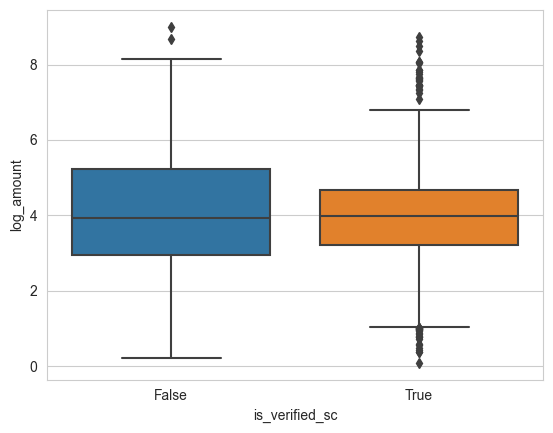

In [18]:
increase_analysis_sub = increase_analysis[increase_analysis["amount"] > 1].copy()
increase_analysis_sub["log_amount"] = np.log10(increase_analysis_sub["amount"])
sns.boxplot(data=increase_analysis_sub[increase_analysis_sub["lp_count"] > 1], y="log_amount", x="is_verified_sc")

<Axes: xlabel='log_amount', ylabel='Count'>

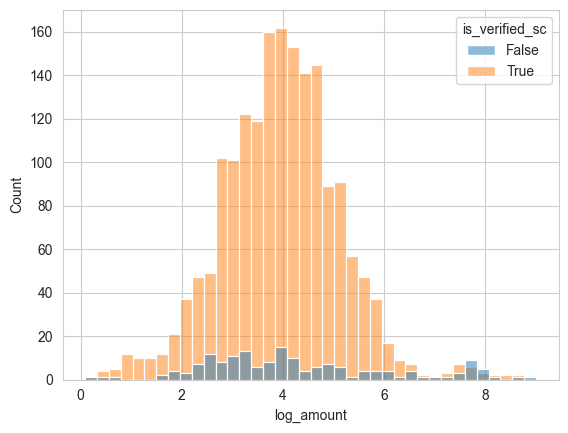

In [19]:
sns.histplot(data=increase_analysis_sub[increase_analysis_sub["lp_count"] > 1],x="log_amount", hue='is_verified_sc')

<Axes: xlabel='log_amount', ylabel='Count'>

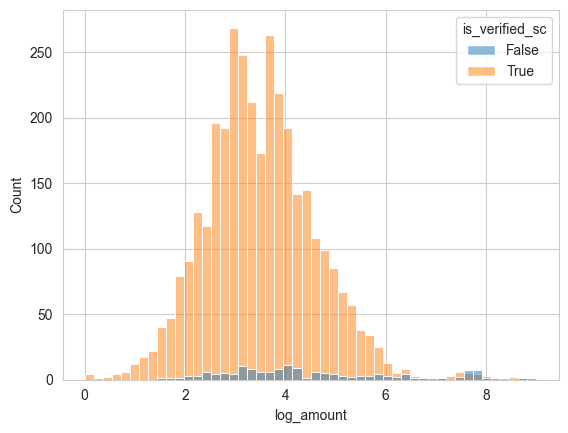

In [21]:
decrease_analysis_sub = decrease_analysis[decrease_analysis["amount"] > 1].copy()
decrease_analysis_sub["log_amount"] = np.log10(decrease_analysis_sub["amount"])
sns.histplot(data=decrease_analysis_sub[decrease_analysis_sub["lp_count"] > 1], x="log_amount", hue='is_verified_sc')

<Axes: xlabel='is_verified_sc', ylabel='log_amount'>

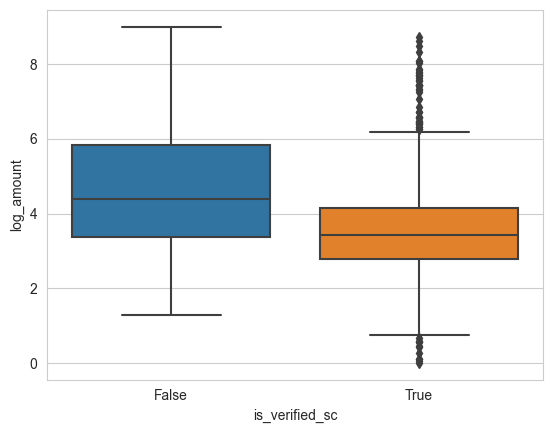

In [22]:
sns.boxplot(data=decrease_analysis_sub, y="log_amount", x="is_verified_sc")

In [23]:
merged_action_df_copy = merged_action_df.copy()
merged_action_df_copy["amount"] = merged_action_df_copy["amount0_usd"] + merged_action_df_copy["amount1_usd"]

In [24]:
merged_action_df_copy_increase_analysis = merged_action_df_copy[merged_action_df_copy["action"] == 'INCREASE_LIQUIDITY'].copy()
merged_action_df_copy_decrease_analysis = merged_action_df_copy[merged_action_df_copy["action"] == 'DECREASE_LIQUIDITY'].copy()

In [25]:
merged_action_df_copy_increase_analysis_sub = merged_action_df_copy_increase_analysis[merged_action_df_copy_increase_analysis["amount"] > 1].copy()
merged_action_df_copy_decrease_analysis_sub = merged_action_df_copy_decrease_analysis[merged_action_df_copy_decrease_analysis["amount"] > 1].copy()
merged_action_df_copy_increase_analysis_sub["log_amount"] = np.log10(merged_action_df_copy_increase_analysis_sub["amount"])
merged_action_df_copy_decrease_analysis_sub["log_amount"] = np.log10(merged_action_df_copy_decrease_analysis_sub["amount"])

<Axes: xlabel='is_verified_sc', ylabel='log_amount'>

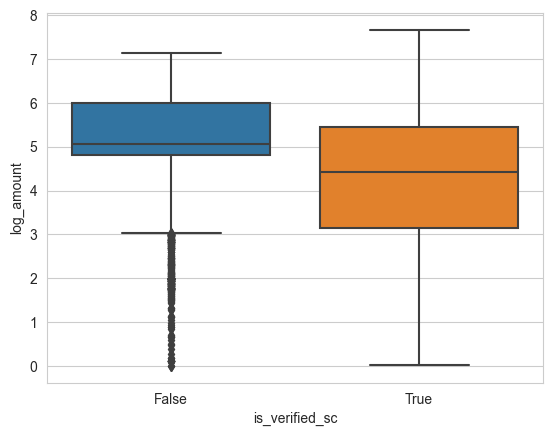

In [26]:
sns.boxplot(data=merged_action_df_copy_increase_analysis_sub[merged_action_df_copy_increase_analysis_sub["lp_count"] > 1], y="log_amount", x="is_verified_sc")

In [27]:
merged_action_df_copy_increase_analysis_sub["is_verified_sc_fixed"] = merged_action_df_copy_increase_analysis_sub["is_verified_sc"] > 0

<Axes: xlabel='log_amount', ylabel='Count'>

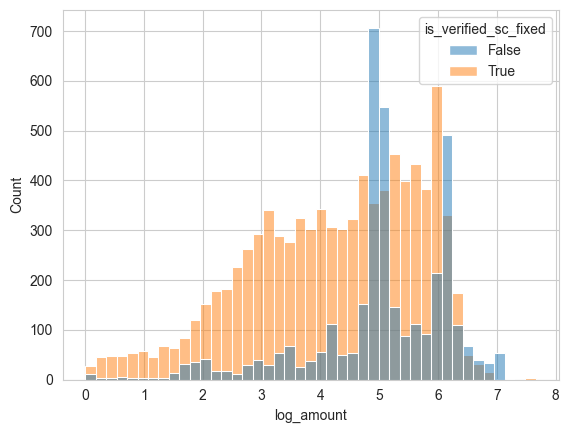

In [28]:
sns.histplot(data=merged_action_df_copy_increase_analysis_sub[merged_action_df_copy_increase_analysis_sub["lp_count"] > 1], x="log_amount", hue='is_verified_sc_fixed')

<Axes: xlabel='is_verified_sc', ylabel='log_amount'>

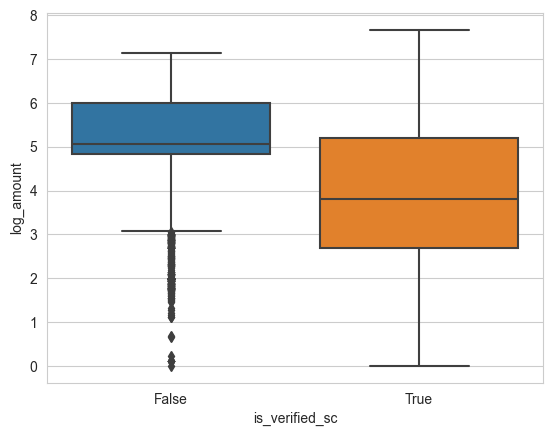

In [29]:
sns.boxplot(data=merged_action_df_copy_decrease_analysis_sub[merged_action_df_copy_decrease_analysis_sub["lp_count"] > 1], y="log_amount", x="is_verified_sc")

<Axes: xlabel='log_amount', ylabel='Count'>

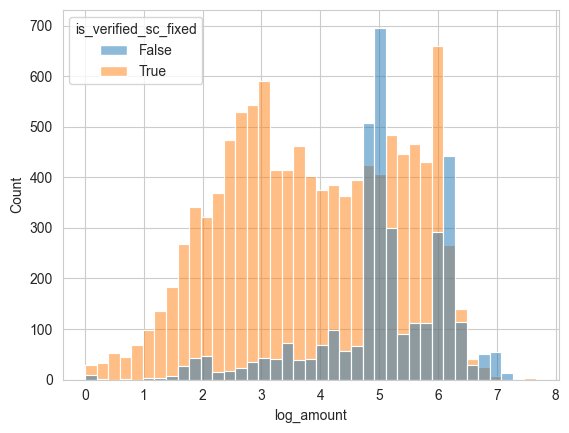

In [30]:
merged_action_df_copy_decrease_analysis_sub["is_verified_sc_fixed"] = merged_action_df_copy_decrease_analysis_sub["is_verified_sc"] > 0
sns.histplot(data=merged_action_df_copy_decrease_analysis_sub[merged_action_df_copy_decrease_analysis_sub["lp_count"] > 1], x="log_amount", hue='is_verified_sc_fixed')

In [34]:
merged_action_df_copy.columns

Index(['blockchain', 'block_number', 'block_timestamp', 'tx_hash', 'action',
       'amount0_adjusted', 'amount1_adjusted', 'amount0_usd', 'amount1_usd',
       'token0_address', 'token1_address', 'token0_symbol', 'token1_symbol',
       'token0_price', 'token1_price', 'liquidity', 'liquidity_adjusted',
       'liquidity_provider', 'nf_position_manager_address', 'nf_token_id',
       'pool_address', 'pool_name', 'tick_lower', 'tick_upper',
       'price_lower_1_0', 'price_upper_1_0', 'price_lower_0_1',
       'price_upper_0_1', 'price_lower_1_0_usd', 'price_upper_1_0_usd',
       'price_lower_0_1_usd', 'price_upper_0_1_usd', 'tx_fee', 'from_address',
       'to_address', 'token_id', 'Unnamed: 0', 'week', 'is_half_verified',
       'is_verified_sc', 'Date_Verified', 'Contract_Name',
       'Contract_Token_Enabled', 'Contract_Token_Name', 'Note', 'lp_count',
       'amount'],
      dtype='object')

In [36]:
merged_action_df_copy["is_verified_sc_fixed"] = merged_action_df_copy["is_verified_sc"] > 0

In [37]:
merged_action_df_copy[['action',
       'amount0_adjusted', 'amount1_adjusted', 'amount0_usd', 'amount1_usd',
       'token0_address', 'token1_address', 'token0_symbol', 'token1_symbol',
       'token0_price', 'token1_price', 'liquidity', 'liquidity_adjusted',
       'liquidity_provider', 'nf_position_manager_address', 'nf_token_id',
       'pool_address', 'pool_name', 'tick_lower', 'tick_upper',
       'price_lower_1_0', 'price_upper_1_0', 'price_lower_0_1',
       'price_upper_0_1', 'price_lower_1_0_usd', 'price_upper_1_0_usd',
       'price_lower_0_1_usd', 'price_upper_0_1_usd', 'tx_fee', 'from_address',
       'to_address', 'token_id', 'week',
       'is_verified_sc_fixed', 'lp_count',
       'amount']].to_stata('step20529.dta')

In [33]:
merged_action_df["is_half_verified"]

0        False
1        False
2        False
3        False
4        False
         ...  
51798    False
51799    False
51800    False
51801    False
51802    False
Name: is_half_verified, Length: 51803, dtype: object

In [53]:
merged_action_df_copy.columns

Index(['blockchain', 'block_number', 'block_timestamp', 'tx_hash', 'action',
       'amount0_adjusted', 'amount1_adjusted', 'amount0_usd', 'amount1_usd',
       'token0_address', 'token1_address', 'token0_symbol', 'token1_symbol',
       'token0_price', 'token1_price', 'liquidity', 'liquidity_adjusted',
       'liquidity_provider', 'nf_position_manager_address', 'nf_token_id',
       'pool_address', 'pool_name', 'tick_lower', 'tick_upper',
       'price_lower_1_0', 'price_upper_1_0', 'price_lower_0_1',
       'price_upper_0_1', 'price_lower_1_0_usd', 'price_upper_1_0_usd',
       'price_lower_0_1_usd', 'price_upper_0_1_usd', 'tx_fee', 'from_address',
       'to_address', 'token_id', 'Unnamed: 0', 'week', 'is_half_verified',
       'is_verified_sc', 'Date_Verified', 'Contract_Name',
       'Contract_Token_Enabled', 'Contract_Token_Name', 'Note', 'lp_count',
       'amount', 'is_verified_sc_fixed'],
      dtype='object')

In [54]:
per_user_level_actions_per_week = merged_action_df_copy[merged_action_df_copy["lp_count"] > 1].groupby(["pool_address", "week", "liquidity_provider", "is_verified_sc_fixed"])[["tx_hash"]].nunique().reset_index()

In [59]:
per_user_level_actions_overall = merged_action_df_copy[merged_action_df_copy["lp_count"] > 1].groupby(["liquidity_provider", "is_verified_sc_fixed"])[["tx_hash"]].nunique().reset_index()

In [70]:
per_user_level_actions_overall["log_tx_hash"] = np.log10(per_user_level_actions_overall["tx_hash"]+1)
per_user_level_actions_per_week["log_tx_hash"] = np.log10(per_user_level_actions_per_week["tx_hash"]+1)

<Axes: xlabel='is_verified_sc_fixed', ylabel='log_tx_hash'>

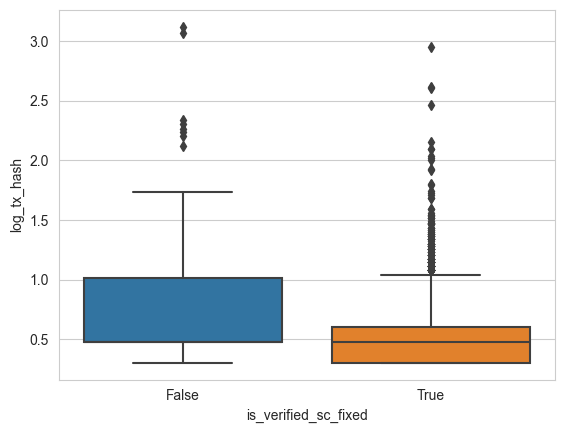

In [71]:
sns.boxplot(data=per_user_level_actions_overall, y="log_tx_hash", x="is_verified_sc_fixed")

<Axes: xlabel='is_verified_sc_fixed', ylabel='log_tx_hash'>

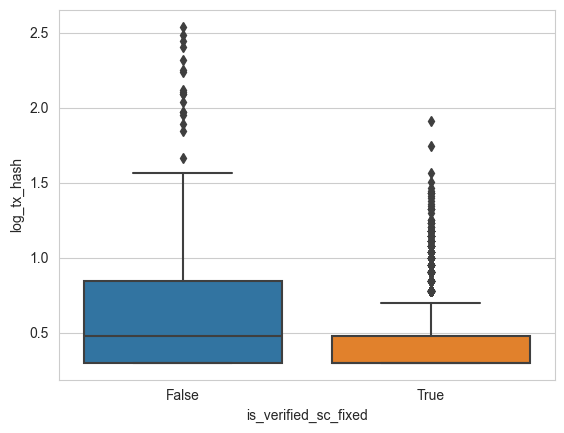

In [72]:
sns.boxplot(data=per_user_level_actions_per_week, y="log_tx_hash", x="is_verified_sc_fixed")